In [ ]:
#| default_exp sleep_plots

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Iterable, Tuple, List

import pandas as pd

import matplotlib.pyplot as plt

from pheno_utils.timeseries_plots import TimeSeriesFigure, plot_events_bars, get_events_period, format_xticks, prep_to_plot_timeseries, DEFAULT_PALETTE

In [ ]:
#| export

CHANNELS = {
    'actigraph': 'Actigraph',
    'body_position': 'Body Position',
    'heart_rate': 'Heart Rate',
    'heart_rate_raw': 'Heart Rate Raw',
    'pat_infra': 'PAT Infra',
    'pat_amplitude': 'PAT Amplitude',
    'pat_lpf': 'PAT LPF',
    'respiratory_movement': 'Respiratory Mov.',
    'spo2': 'SpO2',
    'snore_db': 'Snore dB',
    'pat_view': 'PAT View',
    'sleep_stage': 'Sleep Stage'
    }

DEFAULT_CHANNELS = ['actigraph', 'pat_infra', 'body_position', 'snore_db', 'heart_rate', 'spo2']

# Color groups are designed to match events and raw channels
COLOR_GROUPS= {
    'actigraph': ['actigraph', 'sleep_stage'],
    'general': ['body_position'],
    'heart_rate': ['heart_rate'],
    'heart_rate_raw': ['heart_rate_raw'],
    'pat_amplitude': ['pat_amplitude'],
    'pat_infra': ['pat_infra', 'pat_view', 'pat_lpf'],
    'respiratory_movement': ['respiratory_movement', 'snore_db'],
    'spo2': ['spo2'],
    }

ENUMS = {'body_position': [[0, 1, 2, 3, 4, 5], ['N/A', 'Supine', 'Right', 'Left', 'Prone', 'Sit']],
         'sleep_stage': [[11, 12, 13, 14, 15], ['Wake', 'REM', 'Light', 'End', 'Deep']]}
CHANNEL_LIMS = {'spo2': [0, 100]}

In [ ]:
#| export
def plot_sleep(
    events: pd.DataFrame,
    channels: pd.DataFrame,
    participant_id: int=None,
    array_index: int=None,
    time_range: Tuple[str, str]=None,
    event_filter: Iterable[str]=None,
    channel_filter: Iterable[str]=DEFAULT_CHANNELS,
    event_height: float=1,
    channel_height: float=0.5,
    padding: float=-0.02,
    figsize: Tuple[float, float]=None,
    palette: str=DEFAULT_PALETTE,
) -> TimeSeriesFigure:
    """
    Plot sleep events and channels data.

    Args:

        events (pd.DataFrame): The sleep events dataframe.
        channels (pd.DataFrame): The sleep channels dataframe.
        participant_id (int): The participant id to filter the data.
        array_index (int): The array index to filter the data.
        time_range (Tuple[str, str]): The time range to filter the data.
        event_filter (Iterable[str]): The events to include in the plot.
        channel_filter (Iterable[str]): The channels to include in the plot.
        event_height (float): The relative height of the events subplot.
        channel_height (float): The relative height of each channel's subplot.
        padding (float): The padding between subplots.
        figsize (Tuple[float, float]): The size of the figure.
        palette (str): The color palette to use.

    Returns:

        TimeSeriesFigure: The figure with the sleep events and channels data.
    """
    # Create figure
    if figsize is None:
        if 'source' in channels.index.names:
            nC = channels.index.get_level_values('source').nunique()
        else:
            nC = channels['source'].nunique()
        figsize = 2 * (nC * channel_height + event_height)
        figsize = (8 * 2 * channel_height, figsize)
    g = TimeSeriesFigure(figsize=figsize)

    # Set colors
    channels, color_map = get_channels_colors(
        channels, events,
        participant_id=participant_id, array_index=array_index, time_range=time_range,
        event_filter=event_filter, palette=palette,
    )

    # Plot
    plot_sleep_channels(
        channels,
        x='collection_timestamp', y='values', row='source', hue='channel_group',
        participant_id=participant_id, array_index=array_index, time_range=time_range,
        y_include=channel_filter,
        fig=g, height=channel_height,
        color_map=color_map, palette=palette,
    )
    g.plot(plot_events_bars,
        events,
        x_start='collection_timestamp', x_end='event_end', y='event', hue='channel',
        participant_id=participant_id, array_index=array_index, time_range=time_range,
        y_include=event_filter, y_exclude=['Gross Trunc'],
        palette=palette,
        name='sleep_events', height=event_height, sharex='sleep_channels',
    )
    g.set_axis_padding(padding)

    return g


def plot_sleep_channels(
    channels: pd.DataFrame,
    x: str='collection_timestamp',
    y: str='values',
    row: str='source',
    hue: str='channel_group',
    participant_id: int=None,
    array_index: int=None,
    time_range: Tuple[str, str]=None,
    y_include: Iterable[str]=None,
    y_exclude: Iterable[str]=None,
    rename_channels: dict=CHANNELS,
    discrete_events: Iterable[str]=['sleep_stage', 'body_position'],
    resample: str='1s',
    color_map: pd.Series=None,
    palette: str=DEFAULT_PALETTE,
    fig: TimeSeriesFigure=None,
    ax: List[plt.Axes]=None,
    height=1,
    **kwargs
) -> List[plt.Axes]:
    """ plot channels data for a given participant and array_index """
    # Filter data and prepare channels
    channels, colors = prep_to_plot_timeseries(
        channels, x, x, row, row,
        participant_id, array_index, time_range,
        y_include, y_exclude,
        add_columns=[y, hue], palette=palette
        )
    if color_map is not None:
        colors = color_map

    # Create axes if necessary
    n = channels[row].nunique()
    if ax is None and fig is None:
        fig, ax = plt.subplots(nrows=n, figsize=(12, n*height), sharex=True, squeeze=True)
    elif ax is None:
        ax = fig.add_axes(n_axes=n, height=height, name='sleep_channels')

    # Plot data
    for i, (source, d) in enumerate(channels.groupby(row, observed=True, sort=False)):
        if colors is not None and hue is not None:
            c = colors.get(d[hue].iloc[0], 'grey')
        else:
            c = '#4c72b0'
        if resample is not None:
            d = d.resample(resample, on=x).mean(numeric_only=True).reset_index()

        # Set channel value limits
        if source in CHANNEL_LIMS:
            d = d.loc[
                (CHANNEL_LIMS[source][0] <= d[y]) &
                (d[y] <= CHANNEL_LIMS[source][1])
                ]
        ax[i].scatter(d[x].values, d[y].values, s=0.1, color=c)
        if source not in CHANNEL_LIMS:
            ylim = d[y].quantile([0.001, 0.999]).tolist()
            ylim[0] = 0.95*ylim[0] if ylim[0] >= 0 else 1.1*ylim[0]
            ylim[1] = 1.1*ylim[1] if ylim[1] >= 0 else 0.95*ylim[1]
            ax[i].set_ylim(*ylim)

        if source in rename_channels:
            ax[i].set_ylabel(rename_channels[source], rotation=0, horizontalalignment='right')
        else:
            ax[i].set_ylabel(source, rotation=0, horizontalalignment='right')

        if source in discrete_events:
            if source in ENUMS:
                ax[i].set_yticks(ENUMS[source][0],labels=ENUMS[source][1])
            else:
                ax[i].set_yticks(d[y].drop_duplicates().sort_values().values)
                ylabels = ax[i, 0].get_yticklabels()
                for label in ylabels[1:-1]:
                    label.set_text('')
                ax[i].set_yticklabels(ylabels)

    format_xticks(ax[-1])

    return ax


def get_channels_colors(
    channels: pd.DataFrame,
    events: pd.DataFrame,
    participant_id: int=None,
    array_index: int=None,
    time_range: Tuple[str, str]=None,
    event_filter: Iterable[str]=None,
    palette: str=DEFAULT_PALETTE,
) -> Tuple[pd.DataFrame, pd.Series]:
    # Group channels like events do
    channel_groups = pd.Series(COLOR_GROUPS, name='source')\
        .reset_index()\
        .rename(columns={'index': 'channel_group'})\
        .explode('source').set_index('source')
    channels = channels.join(channel_groups)
    # Simulate events colors
    _, color_map = prep_to_plot_timeseries(
        events,
        x_start='collection_timestamp', x_end='event_end', label='event', hue='channel',
        participant_id=participant_id, array_index=array_index, time_range=time_range,
        y_include=event_filter, y_exclude=['Gross Trunc'],
        palette=palette)

    return channels, color_map

In [ ]:
#| export

def get_sleep_period(events: pd.DataFrame) -> pd.DataFrame:
    """
    Get the sleep period from the sleep events dataframe.

    Args:

        events (pd.DataFrame): The sleep events dataframe.

    Returns:

        pd.DataFrame: The sleep period dataframe.
    """
    return events.groupby(['participant_id', 'research_stage', 'array_index'])\
        .apply(get_events_period, 'Wake', 'Wake', 'Sleep',
               first_start=True, first_end=False, include_start=False, include_end=False)
    

This module provides functions for plotting sleep events and channels data.

First, we will load time series DFs from the sleep monitoring dataset.

In [ ]:
#| eval: false
from pheno_utils import PhenoLoader

pl = PhenoLoader('sleep')
channels_df = pl.load_bulk_data('channels_time_series')  # contains: heart_rate, spo2, respiratory_movement
events_df = pl.load_bulk_data('events_time_series')

/home/ec2-user/projects/pheno-utils/pheno_utils/pheno_loader.py:610: UserWarning: No date field found
  warnings.warn(f'No date field found')


In [ ]:
#| eval: false
channels_df.head(5)

values
participant_id cohort research_stage array_index collection_timestamp             source                      
0              10k    00_00_visit    1           2020-06-23 00:40:29+03:00        heart_rate              62.0
                                                                                  respiratory_movement     0.0
                                                                                  spo2                     NaN
                                                 2020-06-23 00:40:29.200000+03:00 respiratory_movement     0.0
                                                 2020-06-23 00:40:29.400000+03:00 respiratory_movement     0.0

In [ ]:
#| eval: false
events_df.head(5)

event_end  \
participant_id cohort research_stage array_index collection_timestamp                                  
0              10k    00_00_visit    1           2020-06-23 00:40:29+03:00 2020-06-23 00:40:34+03:00   
                                                 2020-06-23 00:40:29+03:00 2020-06-23 00:40:34+03:00   
                                                 2020-06-23 00:40:29+03:00 2020-06-23 00:55:29+03:00   
                                                 2020-06-23 00:40:29+03:00 2020-06-23 00:40:34+03:00   
                                                 2020-06-23 00:40:29+03:00 2020-06-23 00:40:32+03:00   

                                                                                   event  \
participant_id cohort research_stage array_index collection_timestamp                      
0              10k    00_00_visit    1           2020-06-23 00:40:29+03:00      Excluded   
                                                 2020-06-23 00:40:29+03:00      Excluded   
                                                 2020-06-23 00:40:29+03:00          Wake   
                                                 2020-06-23 00:40:29+03:00  Invalid Time   
                                                 2020-06-23 00:40:29+03:00      Artifact   

                                                                                   channel  \
participant_id cohort research_stage array_index collection_timestamp                        
0              10k    00_00_visit    1           2020-06-23 00:40:29+03:00  heart_rate_raw   
                                                 2020-06-23 00:40:29+03:00            spo2   
                                                 2020-06-23 00:40:29+03:00       actigraph   
                                                 2020-06-23 00:40:29+03:00         general   
                                                 2020-06-23 00:40:29+03:00       pat_infra   

                                                                            start  \
participant_id cohort research_stage array_index collection_timestamp               
0              10k    00_00_visit    1           2020-06-23 00:40:29+03:00      0   
                                                 2020-06-23 00:40:29+03:00      0   
                                                 2020-06-23 00:40:29+03:00      0   
                                                 2020-06-23 00:40:29+03:00      0   
                                                 2020-06-23 00:40:29+03:00      0   

                                                                            end  
participant_id cohort research_stage array_index collection_timestamp            
0              10k    00_00_visit    1           2020-06-23 00:40:29+03:00    5  
                                                 2020-06-23 00:40:29+03:00    5  
                                                 2020-06-23 00:40:29+03:00  900  
                                                 2020-06-23 00:40:29+03:00    5  
                                                 2020-06-23 00:40:29+03:00    3

<pheno_utils.timeseries_plots.TimeSeriesFigure>

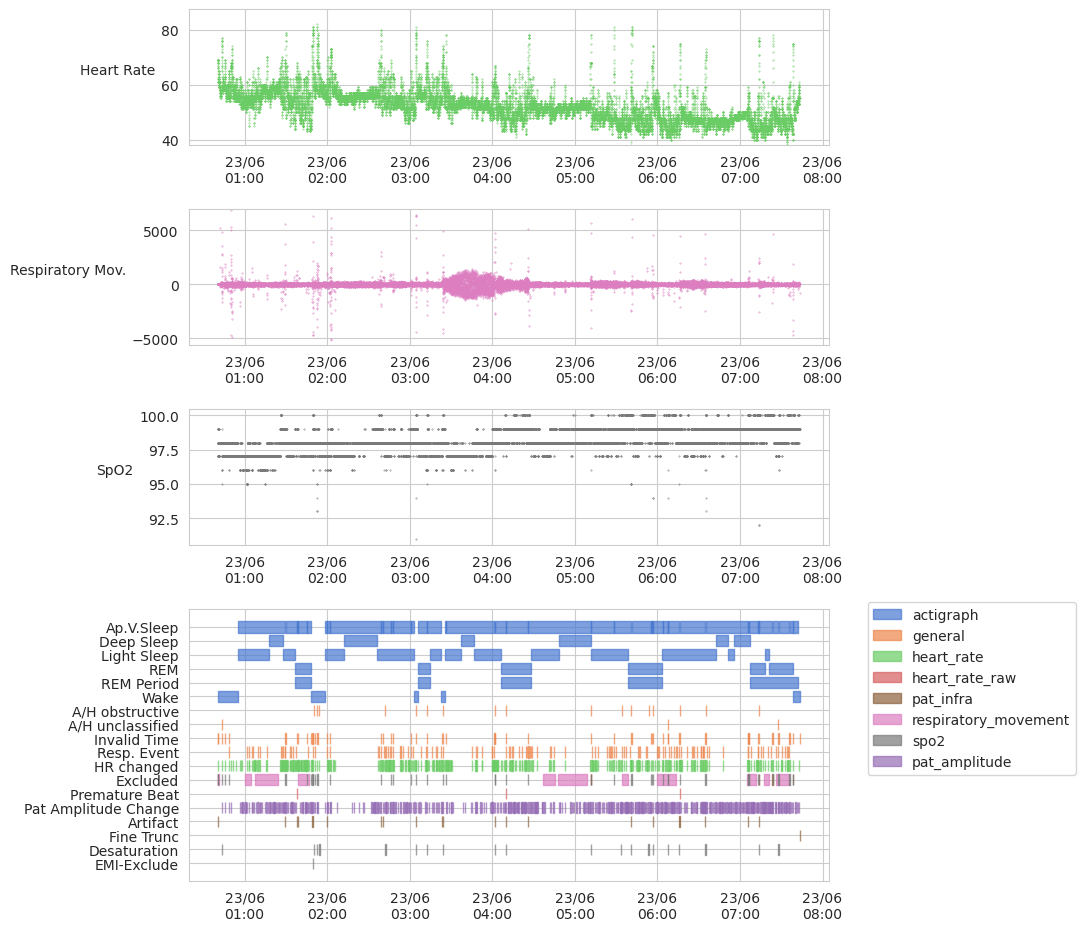

In [ ]:
#| eval: false
import seaborn as sns
sns.set_style('whitegrid')

plot_sleep(events_df, channels_df,
           channel_filter=['heart_rate', 'spo2', 'respiratory_movement'],
           figsize=(8, 8), padding=0.03)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()